In [191]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import ast
from collections import Counter
from wordcloud import WordCloud
from itertools import chain

In [2]:
# Load graph
with open("data/Musicians_graph.pkl", "rb") as f:
    MusiciansG = pickle.load(f)

with open("data/groups_graph.pkl", "rb") as f:
    GroupsG = pickle.load(f)

### Groups Network

In [175]:
# Remove isolates
GroupsG.remove_nodes_from(list(nx.isolates(GroupsG)))
len(GroupsG.nodes)

398

#### Plot giant component

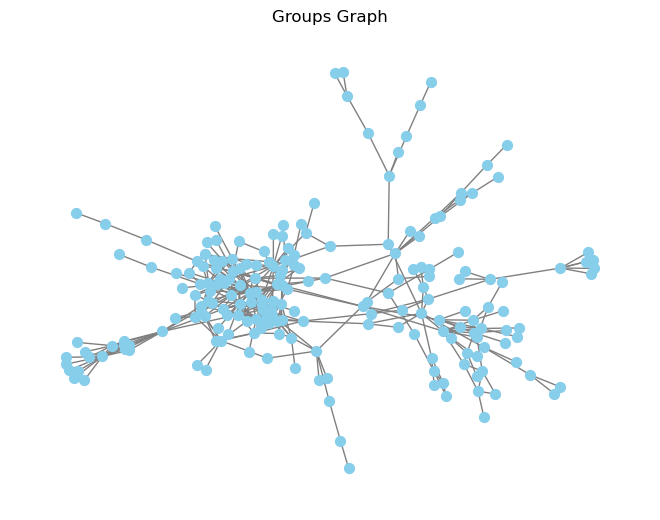

In [3]:
# Get the largest connected component
largest_cc_G = max(nx.connected_components(GroupsG), key=len)

# Create a subgraph of the largest component
G_largest_G = GroupsG.subgraph(largest_cc_G).copy()
nx.draw(G_largest_G, with_labels=False, node_color='skyblue', node_size=50, edge_color='gray')
plt.title("Groups Graph")
plt.show()

Plot with nodes coloured by degree

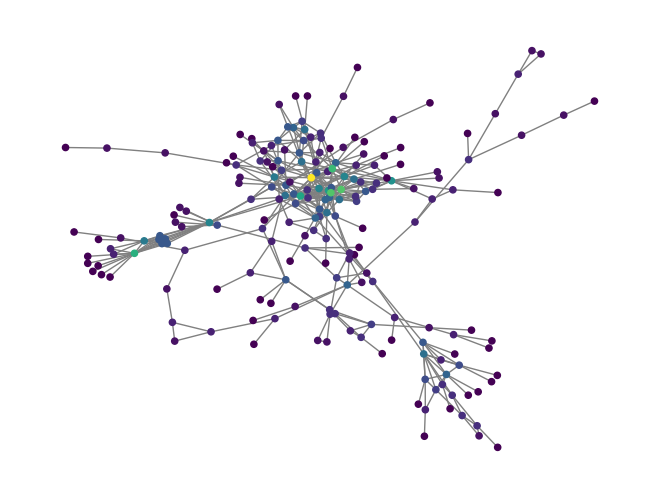

In [8]:
G = G_largest_G
# Compute node degrees
degrees = dict(G.degree())

# Extract degree values for coloring
node_colors = [degrees[node] for node in G.nodes()]

# Draw graph with nodes colored by degree
pos = nx.spring_layout(G, seed=42)  # layout for better visualization
nx.draw(
    G, pos,
    with_labels=False,
    node_color=node_colors,
    cmap=plt.cm.viridis,  # color map: you can try others like 'plasma', 'coolwarm'
    node_size=20,
    edge_color='gray',
    font_weight='bold'
)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])

#### most connected groups

In [325]:
dict_degree = dict(sorted([[band, degree] for band, degree in dict(GroupsG.degree()).items()], key=lambda x: int(x[1]), reverse=True))

#### plot biconnected components

C:\Users\katin\AppData\Local\Temp\ipykernel_12940\2221113718.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(bicomp_edges))


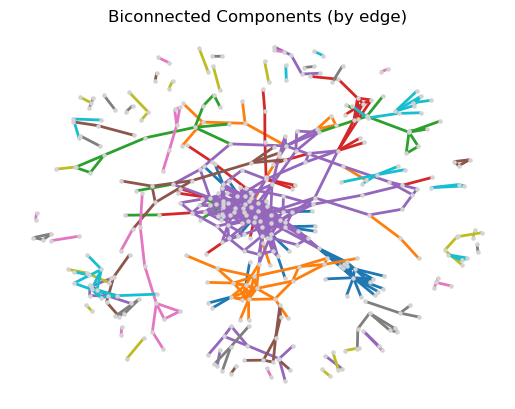

In [318]:
# Get biconnected components as edge sets
bicomp_edges = list(nx.biconnected_component_edges(GroupsG))

# Generate a color for each component
colors = plt.cm.get_cmap('tab10', len(bicomp_edges))

# Create a mapping of edges to colors
edge_color_map = {}
for idx, component in enumerate(bicomp_edges):
    for edge in component:
        edge_color_map[tuple(sorted(edge))] = colors(idx)

# Draw the graph
pos = nx.spring_layout(GroupsG, k=0.12, seed=41)  # consistent layout

# Draw all nodes
nx.draw_networkx_nodes(GroupsG, pos, node_color='lightgray', node_size=5)
#nx.draw_networkx_labels(G, pos)

# Draw edges with assigned colors
for edge, color in edge_color_map.items():
    nx.draw_networkx_edges(GroupsG, pos, edgelist=[edge], edge_color=[color], width=2)

plt.title("Biconnected Components (by edge)")
plt.axis('off')
plt.show()

#### Assign nodes to biconnected clusters (store in dictionary)

In [172]:
# Step 1: Get all biconnected components as sets of nodes
bicomponents = list(nx.biconnected_components(GroupsG))

# Step 2: Sort components by decreasing size
bicomponents.sort(key=lambda c: len(c), reverse=True)

# Step 3: Assign nodes uniquely to clusters
node_to_cluster = {}
assigned_nodes = set()
cluster_id = 1

for component in bicomponents:
    # Get only the unassigned nodes in this component
    unassigned = component - assigned_nodes
    if unassigned:
        for node in unassigned:
            node_to_cluster[node] = cluster_id
        assigned_nodes.update(unassigned)
        cluster_id += 1

In [174]:
node_to_cluster

{'Terje, Jesper & Joachim': 1,
 'Hotel Hunger': 1,
 'Pakhus 1': 1,
 'Young Flowers': 1,
 'Jomfru Ane Band': 1,
 'Rockmaskinen (band)': 1,
 'Anima (band)': 1,
 'Danser med Drenge': 1,
 'The Burning': 1,
 'Led Zeppelin Jam': 1,
 'Mercenary': 1,
 'Naked Fish': 1,
 'Bitch Boys': 1,
 'Naïve': 1,
 'Røde Mor': 1,
 'Daisy (band)': 1,
 'Kim Larsen & Bellami': 1,
 'Dizzy Mizz Lizzy': 1,
 'Escape Artists': 1,
 'Alpha Centauri': 1,
 'Asinhell': 1,
 'HateSphere': 1,
 'Hos Anna': 1,
 'Lars & the Hands of Light': 1,
 "Culpeper's Orchard": 1,
 'Sofamania': 1,
 'Elevatordrengene': 1,
 'Den Gule Negl': 1,
 'Rugsted & Kreutzfeldt': 1,
 'Esben Just Trio': 1,
 'Day Of Phoenix': 1,
 'The Lollipops': 1,
 'Mo-I-Rana (band)': 1,
 'TYG': 1,
 'New Jungle Orchestra': 1,
 'Les Rivals': 1,
 'Kansas City Stompers': 1,
 'Blue Sun': 1,
 'Skullclub': 1,
 'Buki Yamaz': 1,
 'Dig og mig og solskin': 1,
 'Cy, Maia & Robert': 1,
 'Starfuckers': 1,
 'Anne Linnet Band': 1,
 'Tears': 1,
 'Christianshavns Bluesband': 1,
 'The B

### Text analysis

In [282]:
df_groups = pd.read_csv("data/groups_wMembers_Text.csv")[["title", "intro_text"]]

In [283]:
def clean_text(text):
    if not isinstance(text, str):
        return {}
    clean_text = re.sub(r'<.*?>', '', text)
    wordlist = [re.sub(r"[^a-zA-ZæøåÆØÅ]+", '', word.lower()) for word in clean_text.split() if re.sub(r"[^a-zA-Z]+", '', word.lower())]
    return wordlist
    N = len(wordlist)
    TF = {str(word): 0 for word in np.unique(wordlist)}
    for word in wordlist:
        TF[word] +=1/N
    return TF

In [284]:
df_groups["textlist"] = df_groups["intro_text"].apply(clean_text)

In [ ]:
#df_groups[["title", "textlist"]].to_csv("data/groups_cleantext.csv", index = False) 

In [286]:
def group2comfunc(group):
    try:
        return node_to_cluster[group]
    except:
        return None

df_groups["community"] = df_groups["title"].apply(group2comfunc)
df_groups = df_groups.dropna(subset=['community'])
df_groups = df_groups.reset_index(drop=True)

In [287]:
with open("data/da_DK.dic", encoding="utf-8") as f:
    danish_words = set()
    for line in f:
        word = line.strip().split("/")[0]  # Remove affixes
        danish_words.add(word.lower())

print(f"Loaded {len(danish_words)} Danish words.")

Loaded 152366 Danish words.


In [309]:
for letter in "abcdefghjklmnopqrstuvxyzæ":
    if letter in danish_words:
        danish_words.remove(letter)

In [ ]:
com_members = df_groups.groupby('community')['title'].apply(
    lambda x: [band for band in x])

In [420]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')

In [466]:
member_names = list(pd.read_csv("data/musicians_wMembers.csv")["name"].apply(lambda x: str(x).split()))
member_names = [name.lower() for person in member_names for name in person]

In [467]:
group_names = list(df_groups["title"].apply(lambda x: x.split()))
group_names = [word.lower() for groupname in group_names for word in groupname]

In [469]:
def filter_text(word_lists, danish_words): #to only include words from danish dictionary, and not stop words
    all_words = chain.from_iterable(word_lists)
    return [word for word in all_words if (word in danish_words) and (word not in stop_words) and (word not in member_names) and (word not in group_names)]

com_words = df_groups.groupby('community')['textlist'].apply(
    lambda x: filter_text(x, danish_words)
)

In [470]:
communities = pd.DataFrame({
    'community': range(1, len(com_members) + 1),
    'groups': list(com_members),
    'com_words': list(com_words) })

In [471]:
communities

,community,groups,com_words
0,1,"[Big Fat Snake, Bitch Boys, Blue Sun, Charlata...","[dansk, musikgruppe, inden, dannet, besætning,..."
1,2,"[Det Jyske Ensemble, Theatre of Voices, Ensemb...","[oprettet, daværende, tidspunkt, bestod, blæse..."
2,3,"[Singvogel, Amdi Petersens Armé, Gorilla Angre...","[dansk, rockband, dannet, december, tekstforfa..."
3,4,"[Einstein (rockband), Hardinger Band, Passport...","[se, se, artikler, begynder, rockband, bestod,..."
4,5,"[Almune, Asynje (band), Trolska Polska, Valrav...","[dansk, bestående, sang, fløjte, tromme, percu..."
...,...,...,...
158,159,[Gny],"[dansk, folkemusik, gruppe, spiller, nordisk, ..."
159,160,[Bazookahosen],"[dansk, dannet, november, alfabetisk, rækkeføl..."
160,161,[MellemFingaMuzik],"[skrevet, dansk, bestående, bedre, kendt]"
161,162,[Skarpretter (band)],"[få, ingen, artikel, hvilket, problem, kan, hj..."


In [472]:
df_genres = pd.read_csv("data/groups_wMembers_Text_Genres.csv")[["title", "genres"]]
dict_genres = df_genres.set_index('title')['genres'].apply(lambda x: ast.literal_eval(x)).to_dict()

In [473]:
communities["genres"] = communities["groups"].apply(lambda x: [genre for group in x for genre in dict_genres[group]])

In [474]:
communities

,community,groups,com_words,genres
0,1,"[Big Fat Snake, Bitch Boys, Blue Sun, Charlata...","[dansk, musikgruppe, inden, dannet, besætning,...","[pop, rock, rock, pop, rock, jazz, blues, pop,..."
1,2,"[Det Jyske Ensemble, Theatre of Voices, Ensemb...","[oprettet, daværende, tidspunkt, bestod, blæse...","[classical, opera, choral, classical, brass ba..."
2,3,"[Singvogel, Amdi Petersens Armé, Gorilla Angre...","[dansk, rockband, dannet, december, tekstforfa...","[rock, hardcore punk, punk, rock, hardcore pun..."
3,4,"[Einstein (rockband), Hardinger Band, Passport...","[se, se, artikler, begynder, rockband, bestod,...","[rock, schlager (dansk top), rock, blues, pop,..."
4,5,"[Almune, Asynje (band), Trolska Polska, Valrav...","[dansk, bestående, sang, fløjte, tromme, percu...","[folk, folk, folk, electronic, folk, heavy met..."
...,...,...,...,...
158,159,[Gny],"[dansk, folkemusik, gruppe, spiller, nordisk, ...","[heavy metal, folk]"
159,160,[Bazookahosen],"[dansk, dannet, november, alfabetisk, rækkeføl...","[indie rock, blues, opera, world]"
160,161,[MellemFingaMuzik],"[skrevet, dansk, bestående, bedre, kendt]",[hip hop]
161,162,[Skarpretter (band)],"[få, ingen, artikel, hvilket, problem, kan, hj...","[rock, punk]"


In [475]:
def freq(wordlist):
    word_counts = Counter(wordlist)
    total = sum(word_counts.values())
    word_freq = {word: round(count / total,3) for word, count in word_counts.items()}
    sorted_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    return sorted_freq

communities["genrecount"] = communities["genres"].apply(freq)
communities["genrecount"][3]

{'rock': 0.5, 'pop': 0.25, 'schlager (dansk top)': 0.125, 'blues': 0.125}

#### IDF

In [476]:
all_words = []
for com in com_words:
    all_words.extend(com)
word_counts = Counter(all_words)
unique_words = list(word_counts.keys())

def IDF(words):
    N = len(com_words)
    DF_dict = {word: 0 for word in words}

    for com in com_words:
        com_set = set(com)
        for word in words: 
            if word in com_set:
                DF_dict[word] +=1

    IDF_dict = {word: float(np.log(N/DF_dict[word])) for word in words}    
    return IDF_dict

IDF_dict = IDF(unique_words)

In [481]:
for com in range(30):
    words = communities["com_words"][com] # getting the wordlist for the given community
    TF = Counter(words) # creating dictionary of counts
    TF_IDF = {word: TF[word] * IDF_dict[word] for word in words}
    most_TFIDF_words = Counter(TF_IDF).most_common(20)
    top_groups = sorted({group: dict_degree[group] for group in communities["groups"][com]}.items(), key = lambda x: x[1], reverse = True)
    print("--------------------------------")
    print(f"Community {com}")
    print(f"groups in community: {len(communities['groups'][com])}")
    print(f"top 5 groups, by degree: {[x[0] for x in top_groups[:5]]}")
    print(f"top genres: {list(communities['genrecount'][com].keys())[:3]}")
    print(f"Top TF-IDF words: {', '.join(np.asarray(most_TFIDF_words)[:,0])}")

--------------------------------
Community 0
groups in community: 103
top 5 groups, by degree: ['Kansas City Stompers', 'Frede Fup', 'Lone Kellermann og Rockbandet', 'Delta Cross Band', 'Starfuckers']
top genres: ['rock', 'pop', 'jazz']
Top TF-IDF words: sang, sanger, spillede, guitarist, bas, navn, første, gruppe, år, omkring, kendte, københavn, amerikanske, dannet, skak, samt, kor, periode, metal, aldrig
--------------------------------
Community 1
groups in community: 13
top 5 groups, by degree: ['Odense Symfoniorkester', 'Det Kongelige Kapel', 'Esbjerg Ensemble', 'Århus Sinfonietta', 'DR Symfoniorkestret']
top genres: ['classical', 'choral', 'opera']
Top TF-IDF words: chefdirigent, musik, grammy, ældste, verdens, grundlagt, oprettet, repertoire, kaija, match, hjemsted, vestjysk, kina, påske, blokfløjte, fastansatte, lang, store, moderne, mere
--------------------------------
Community 2
groups in community: 13
top 5 groups, by degree: ['Gorilla Angreb', 'No Hope for the Kids', 'Sin

### Musicians

In [478]:
# Get the largest connected component
largest_cc_M = max(nx.connected_components(MusiciansG), key=len)

# Create a subgraph of the largest component
G_largest_M = MusiciansG.subgraph(largest_cc_M).copy()

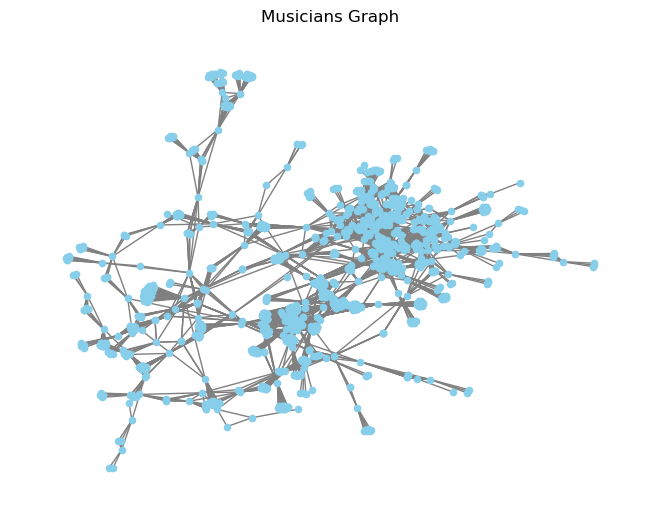

In [479]:
nx.draw(G_largest_M, with_labels=False, node_color='skyblue', node_size=20, edge_color='gray')
plt.title("Musicians Graph")
plt.show()